# Ostateczne Modelowanie

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
# wczytanie ramki danych ze zliczonymi wystąpieniami słów
df = pd.read_csv('AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv')

## Utworzenie nowych cech:
- liczba słów w rozdziale,
- średnia długość słowa w rozdziale (w literach),
- liczba zdań w rozdziale,
- średnia długość zdania w rozdziale (w słowach).

In [2]:
# wczytanie tekstów
with open('AsianReligionsData/Complete_data.txt', 'r',encoding='latin-1') as file:
    text = file.read()
text = re.split(r'\n\d\.\d+\n', text)
text = [re.sub(r'\d\.\d+\n','',i) for i in text]

# podział na słowa
word = re.compile(r'\b([A-Za-z]+)\b')
words = list(map(word.findall, text))

# podział na zdania
sentence = re.compile(r'\b([A-Z].*?[.!?]+)[\b\s\W]')
sentences = list(map(sentence.findall, text))

# obliczenie pewnych statystyk
n_words = [len(x) for x in words] # liczba słów w rozdziale
mean_word_len = [np.mean(list(map(len, x))) for x in words] # średnia długość słowa w rozdziale (w literach)
n_sentences = [len(x) for x in sentences] # liczba zdań w rozdziale
mean_sentence_len = [np.mean(list(map(lambda x:len(word.findall(x)), x))) for x in sentences] # średnia długość zdania w rozdziale (w słowach)

# poprawki
mean_word_len[13] = 0.0
mean_sentence_len[13] = 0.0
n_sentences[145] = 1
mean_sentence_len[145] = float(len(word.findall(text[145])))

# dodanie do ramki danych
df['n_words'] = n_words
df['mean_word_len'] = mean_word_len
df['n_sentences'] = n_sentences
df['mean_sentence_len'] = mean_sentence_len

## Podział ksiąg na dwie grupy:
- księgi chrześcijańskie,
- księgi niechrześcijańskie.

In [3]:
p = r'[A-Za-z]+'
book = re.compile(p)
books = list(map(lambda x: book.match(x).group(), df[df.columns[0]]))
df['book_name'] = books

le = preprocessing.LabelEncoder()
df['book_name'] = le.fit_transform(df['book_name'])

book_groups = {'BookOfEccleasiasticus':0,
 'BookOfEcclesiastes':0,
 'BookOfProverb':0,
 'BookOfWisdom':0,
 'Buddhism':1,
 'TaoTeChing':1,
 'Upanishad':1,
 'YogaSutra':1}

gbooks = books.copy()
for i in range(len(books)):
    gbooks[i] = book_groups[books[i]]

## Oryginalny podział na osiem ksiąg

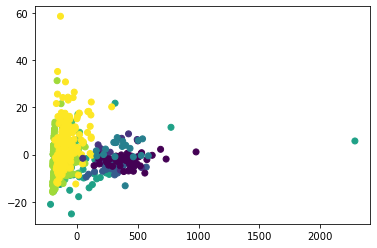

In [4]:
X = df[df.columns[-5:-1]]
pca = PCA(n_components=2)
X = pca.fit_transform(X)
plt.scatter(pd.DataFrame(X)[0],pd.DataFrame(X)[1], c=df['book_name'])
plt.show()

## Przetestowanie metod klasteryzujących

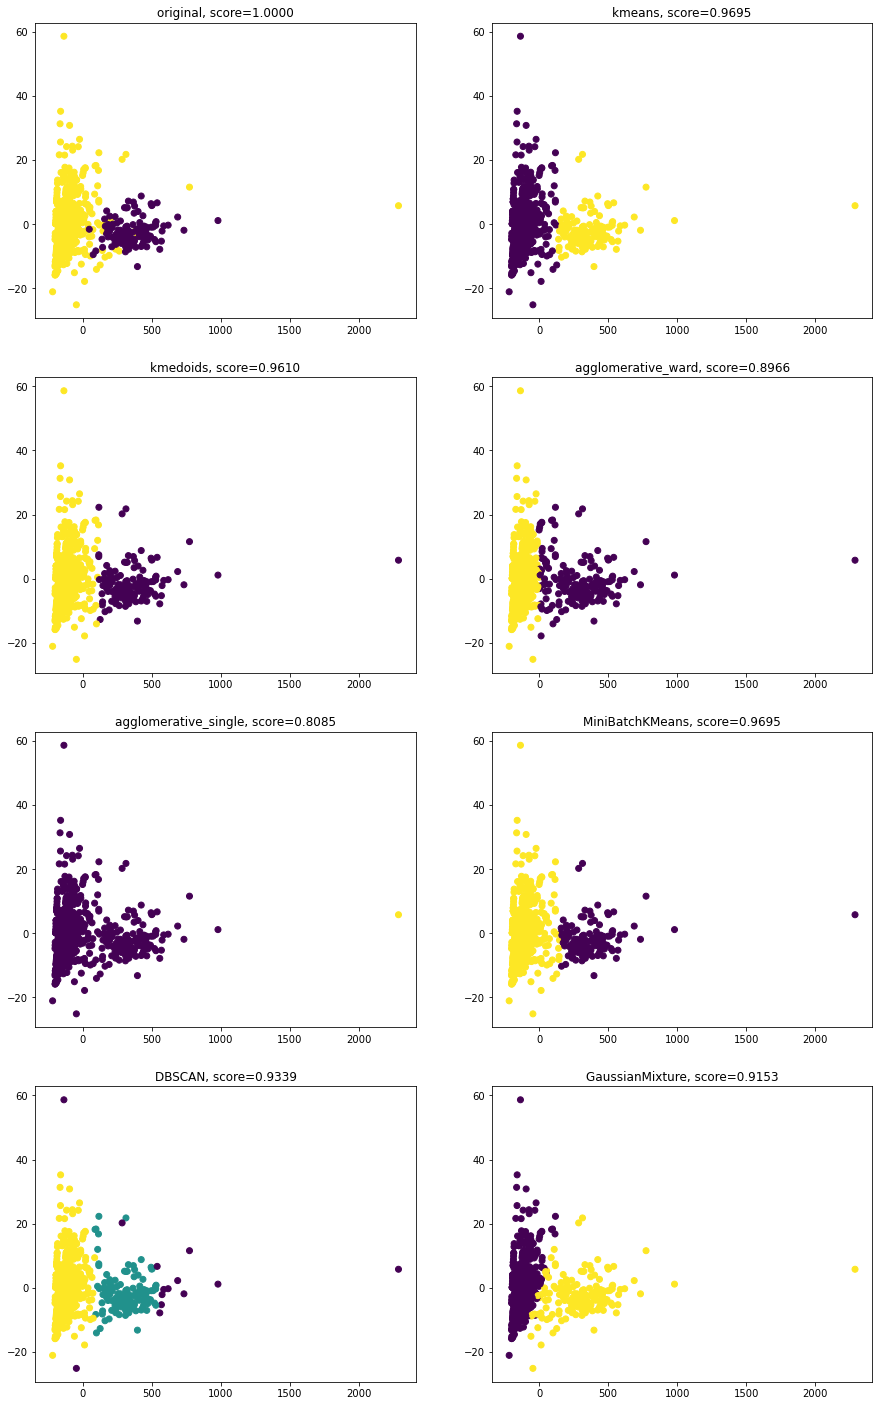

In [5]:
X = df[df.columns[-5:-1]]
n_clusters = 2

models = []

models.append(KMeans(n_clusters=n_clusters, random_state=0))
models.append(KMedoids(n_clusters=n_clusters, random_state=0))
models.append(AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward'))
models.append(AgglomerativeClustering(n_clusters=n_clusters, linkage = 'single'))
models.append(MiniBatchKMeans(n_clusters=n_clusters))
models.append(DBSCAN(eps=22, min_samples=8))
models.append(GaussianMixture(n_components=n_clusters, covariance_type='diag'))

labels = [gbooks]

for model in models:
    labels.append(model.fit_predict(X))
    
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_df = pd.DataFrame(X_pca)

scores = []
for label in labels:
    a = sum(np.array(gbooks)==label)/len(gbooks)
    scores.append(a if a > 0.5 else 1-a)
    
((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.figure(figsize=(15,25)).subplots(4,2)
plots = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i,plot in enumerate(plots):
    plot.scatter(X_df[0], X_df[1], c = labels[i])
    
ax1.set_title(f'original, score={scores[0]:.4f}')
ax2.set_title(f'kmeans, score={scores[1]:.4f}')
ax3.set_title(f'kmedoids, score={scores[2]:.4f}')
ax4.set_title(f'agglomerative_ward, score={scores[3]:.4f}')
ax5.set_title(f'agglomerative_single, score={scores[4]:.4f}')
ax6.set_title(f'MiniBatchKMeans, score={scores[5]:.4f}')
ax7.set_title(f'DBSCAN, score={scores[6]:.4f}')
ax8.set_title(f'GaussianMixture, score={scores[7]:.4f}')

plt.show()